In [1]:
%matplotlib inline

import gpxpy
import json
import os
import psycopg2
from socket import gethostname

import requests
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

from shapely.geometry import Point,LineString,Polygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

import requests
import time

from ipywidgets import widgets

data_dir = "../../../data/"
deg2km = 111
crs_default={'init': 'epsg:4326'}
hostname = gethostname()

In [2]:
with open(os.path.join("./config.json")) as f:
    config = json.load(f)
conn = psycopg2.connect(**config['db'][hostname])
config['db'][hostname]['user']     = '********'
config['db'][hostname]['password'] = '********'

config['buffer'] = 2
def f(x):
    config['buffer'] = x
    print(x)
# http://ipywidgets.readthedocs.io/en/stable/user_install.html
widgets.interact(f, x=widgets.IntSlider(min=1,max=11,step=1,value=6));


6


In [3]:
dataframe_gasstations = pd.read_sql_query('select * from "gas_station"',con=conn)
# https://cambridgespark.com/content/tutorials/geopandas/index.html
geometry = [Point(xy) for xy in zip(dataframe_gasstations.lng, dataframe_gasstations.lat)]
geodataframe_stations = gpd.GeoDataFrame(dataframe_gasstations, crs=crs_default, geometry=geometry)
conn.close()

In [4]:
gpx_file = open(data_dir+'WOB-LDK.gpx', 'r')
gpx_file_parsed = gpxpy.parse(gpx_file)
# create a Pandas DataFrame as a starter
list_gpx_data = []
for track in gpx_file_parsed.tracks:
    for segment in track.segments:
        for point in segment.points:
            list_gpx_data.append([point.longitude, point.latitude])
columns = ['Longitude', 'Latitude']
dataframe_track = pd.DataFrame(list_gpx_data, columns=columns)

line_track = LineString(list_gpx_data)
line_track_buffered = line_track.buffer(config['buffer']/deg2km)

geodataframe_track_buffered = gpd.GeoDataFrame.from_dict(list_gpx_data)

import shapely.wkt
from shapely.geometry import Point
# Now create a GeoPandas DataFrame from it
#https://gis.stackexchange.com/a/174168/87254 et al
geodataframe_track = gpd.GeoDataFrame(dataframe_track.drop(['Longitude', 'Latitude'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=dataframe_track.apply(lambda row: shapely.geometry.Point((row.Longitude, row.Latitude)), axis=1))

#bufferedpolygon_track = geodataframe_track.unary_union.buffer(config['buffer']/deg2km)

In [5]:
stations_in_vincinity = []

for index, row in geodataframe_stations.iterrows():
    #print(row)
    if row.geometry.within(line_track_buffered):
        #print(row["id"], row["place"])
        stations_in_vincinity.append(row)

In [6]:
#http://stackoverflow.com/a/9671301
chunks = [stations_in_vincinity[x:x+10] for x in range(0, len(stations_in_vincinity), 10)]
print("." * len(chunks), end="\n")

parameters2 = []
for chunk in range(len(chunks)):
    somedict2 = {}
    somelist2 = []
    somedict2['apikey'] = config["tk"]["apikey"]
    for station in range(len(chunks[chunk])):
        somelist2.append(chunks[chunk][station]['id'])
    somedict2['ids'] = ",".join(somelist2)
    parameters2.append(somedict2)
#print(parameters2)
responses = []
url='https://creativecommons.tankerkoenig.de/json/prices.php'
for each in parameters2:
    response = requests.get(url, params=each)
    if (response.status_code != 200):
        print("Attention! Status code is {}.".format(response.status_code))
    data = response.json()
    responses.append(data)
    print(".", end="")
    time.sleep(4)

.......................
.......................

In [7]:
import numpy as np

valid_responses = {}
#for response in range(len(responses)):
for response in range(len(responses)):
    #print(responses[response])
    for chunk in range(len(responses[response])):
        #print(responses[response]['prices'], "....", chunk)
        for index, row in responses[response]['prices'].items():
            #print(responses[response]['prices'][index])
            if responses[response]['prices'][index]['status'] == 'open':
                #valid_responses.append(responses[response]['prices'][index])
                valid_responses[index] = responses[response]['prices'][index]

#
dataframe_stations_in_vincinity = pd.DataFrame(stations_in_vincinity)
dataframe_stations_in_vincinity = dataframe_stations_in_vincinity.set_index('id')

dataframe_stations_valid_responses = pd.DataFrame(valid_responses)
dataframe_stations_valid_responses = dataframe_stations_valid_responses.T

In [8]:
dataframe_analysis = pd.concat([dataframe_stations_in_vincinity, dataframe_stations_valid_responses], axis=1)
dataframe_analysis[['diesel', 'e5', 'e10']] = dataframe_analysis[['diesel', 'e5', 'e10']].astype(float)
dataframe_analysis.diesel = dataframe_analysis.diesel.replace({ 0 : np.nan })
dataframe_analysis.e5 = dataframe_analysis.e5.replace({ 0 : np.nan })
dataframe_analysis.e10 = dataframe_analysis.e10.replace({ 0 : np.nan })

dataframe_analysis = dataframe_analysis[dataframe_analysis['e5'] > 0]

#dataframe_analysis.describe()
#dataframe_analysis.columns.values

# https://stackoverflow.com/a/28577480
# cols_to_norm = ['diesel','e10', 'e5']
dataframe_analysis[['diesel_norm','e10_norm', 'e5_norm']] = dataframe_analysis[['diesel','e10', 'e5']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [ ]:
dataframe_analysis[['diesel', 'e10', 'e5', 'diesel_norm', 'e10_norm', 'e5_norm']].describe()

In [9]:
geometry = [Point(xy) for xy in zip(dataframe_analysis.lng, dataframe_analysis.lat)]
geodataframe_analysis = gpd.GeoDataFrame(dataframe_analysis[['name', 'brand', 'post_code', 'place', 'lat', 'lng', 'diesel', 'e10', 'e5','diesel_norm', 'e10_norm', 'e5_norm', 'status', 'geometry']], crs=crs_default, geometry=geometry)



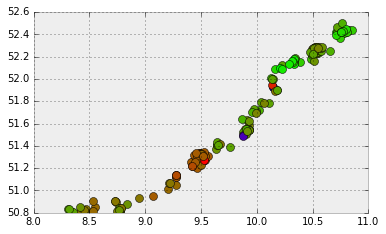

In [10]:
geodataframe_analysis.plot(column='e5', cmap='brg_r', markersize=8)

In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap

In [ ]:
map = folium.Map([52, 8.4],
                  zoom_start=7,
                  tiles='cartodbpositron')

maxe5 = dataframe_analysis['e5_norm'].max()

#marker_cluster = MarkerCluster().add_to(map)
#for index, row in dataframe_analysis.iterrows():
#    #print(row.geometry)
#    folium.Marker([row.lat, row.lng],popup=row.name+': '+str(row.e5)).add_to(marker_cluster)
#
#points = folium.features.GeoJson(gjson)
#map.add_child(points)

stationArr = dataframe_analysis[['lat', 'lng', 'e5_norm']].values.tolist()
hm_wide = HeatMap( stationArr, 
                   min_opacity=0.0,
                   radius=12, blur=12, 
                   max_zoom=9,
                   gradient={0.0: 'green', 0.5: 'yellow', 1: 'red'}
                 )
map.add_child(hm_wide)

# map